# **Come si fa ad avere successo su Ted?**
**Progetto realizzato da**: Siri Filippo (4819642) \
**Dataset**: TED Talks

In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [153]:
ted = pd.read_csv('data.csv')

Dopo aver importato le varie librerie necessarie ed il file CSV, iniziamo l'analisi del dataset andando a vedere le colonne presenti e la dimensione del dataset.

In [154]:
ted.head()

,title,author,date,views,likes,link
0,Climate action needs new frontline leadership,Ozawa Bineshi Albert,December 2021,404000,12000,https://ted.com/talks/ozawa_bineshi_albert_cli...
1,The dark history of the overthrow of Hawaii,Sydney Iaukea,February 2022,214000,6400,https://ted.com/talks/sydney_iaukea_the_dark_h...
2,How play can spark new ideas for your business,Martin Reeves,September 2021,412000,12000,https://ted.com/talks/martin_reeves_how_play_c...
3,Why is China appointing judges to combat clima...,James K. Thornton,October 2021,427000,12000,https://ted.com/talks/james_k_thornton_why_is_...
4,Cement's carbon problem — and 2 ways to fix it,Mahendra Singhi,October 2021,2400,72,https://ted.com/talks/mahendra_singhi_cement_s...


In [155]:
print(f"Righe: {ted.shape[0]}")
print(f"Colonne: {ted.shape[1]}")

Righe: 5440
Colonne: 6


Per prima cosa analizziamo le feature del dataset dividendole in qualitative e quantitative. In questo modo andiamo possiamo farci una prima idea dei valori presenti ed andiamo a trovare eventuali valori nulli.

In [156]:
ted_quantitative = ted[['views','likes']]
ted_qualitative = ted[['title', 'author', 'date', 'link']]

In [157]:
ted_quantitative.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,views,likes
count,5440.00000,5440.00000
mean,2061575.95790,62607.61673
std,3567097.76512,107646.76946
min,532.00000,15.00000
25%,670750.00000,20000.00000
50%,1300000.00000,40500.00000
75%,2100000.00000,65000.00000
max,72000000.00000,2100000.00000


Le feature quantitative presenti nel dataset `views` e `likes`. È possibile notare che non sono presenti valori nulli e che non esistono talks che non sono mai stati guardati (valore minimo di views 532) o che non hanno ricevuto nemmeno un like. 

In [158]:
ted_qualitative.describe()

,title,author,date,link
count,5440,5439,5440,5440
unique,5440,4443,200,5440
top,Climate action needs new frontline leadership,Alex Gendler,April 2018,https://ted.com/talks/ozawa_bineshi_albert_cli...
freq,1,45,127,1


Le feature qualitative presenti nel dataset sono `title`, `author`, `date` e `link`. Si può notare che non esistono talks con lo stesso titolo e che un autore può pubblicare diversi talks. Abbiamo anche trovato che l'autore che ha pubblicato il maggior numero di talks è `Alex Gendler`. Siccome sono presenti 5439 valori per la feature `author`, vuol dire che è presente un talk con il campo `author` nullo.

In [159]:
ted[ted.isnull().any(axis=1)]

,title,author,date,views,likes,link
3039,Year In Ideas 2015,NaN,December 2015,532,15,https://ted.com/talks/year_in_ideas_2015


Abbiamo trovato che il talk con `author` nullo è un video che racchiude parti dei vari talk presentati durante l'anno. Decidiamo di rimpiazzare il valore nullo con `Unknown author`.

In [160]:
ted['author'].fillna('Unknown author', inplace=True)
ted.isnull().sum()

title     0
author    0
date      0
views     0
likes     0
link      0
dtype: int64

### **Le persone sono ancora interessate ai TED Talk?**
Se una persona parte da zero la prima cosa che deve chiedersi è se ha ancora senso pubblicare dei talk o se le persone hanno perso interesse. Per questo motivo andiamo a vedere l'andamento di pubblicazioni e views nel corso degli anni.

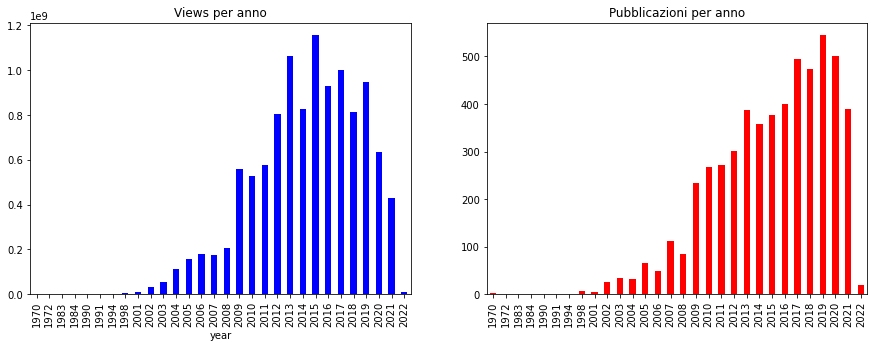

In [161]:
ted['year'] = [int(x) for x in ted['date'].str.split(' ', expand=True)[1]]

views = ted.groupby('year')['views'].sum()#/ted['views'].sum() #normalizzazione
year = ted['year'].value_counts().sort_index()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
views.plot(kind='bar', color='blue', title="Views per anno")
plt.subplot(1,2,2)
year.plot(kind='bar', color='red', title="Pubblicazioni per anno")




Si può notare che sino al 2015 c'è stata una crescita continua nel numero di views e di pubblicazioni. \
A partire dal 2015 la gente ha iniziato a perdere interesse visto che il numero di views ha iniziato a diminuire. \
Siccome la gente ha iniziato a perdere interesse, probabilmente adesso è più difficile avere successo e registrare numeri elevati rispetto a qualche anno fa. \
Una cosa interessante da notare è che nonostante il calo del numero di views sono continuati gli investimenti nella piattaforma, infatti sino al 2019 il numero di pubblicazioni ha continuato a crescere. \
A partire dal 2020 invece sono diminuite pure le pubblicazioni, ma potrebbe essere anche un effetto della pandemia visto che non è stato possibile fare molte conferenze. \
Siccome fino all'arrivo del Covid il numero di pubblicazioni (e quindi di investimenti) aumentava nonostante la diminuzione nel numero di views ha comunque senso iniziare per provare ad emergere (nonostante la diminuzione di interesse da parte delle persone).



### **Qual è il nostro vero obiettivo?**
Il nostro obiettivo è di realizzare talk che ottengono il maggior numero di like, quindi che piacciono alla maggior parte della gente.
Per prima cosa andiamo a vedere se, come pensiamo, esiste una correlazione tra il numero di like ed il numero di view.

In [162]:
print(f"Correlazione (likes/views): {ted['likes'].corr(ted['views'])}")

Correlazione (likes/views): 0.9996610444062041


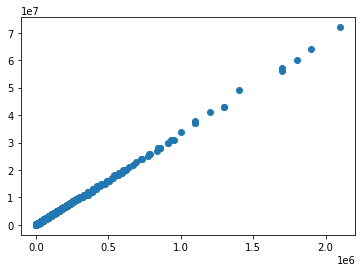

In [163]:
plt.scatter(ted['likes'], ted['views']) #todo: mettere label x e y

Si può notare che è presente una forte correlazione, quindi implementiamo ed alleniamo un modello di regressione lineare che dato un numero di like che vogliamo ottenere stima un numero di view necessario. \
Per realizzare il modello dividiamo il dataset nel training set che utilizziamo per allenare il modello e nel validation set che utilizziamo per verificare il modello. Utilizziamo un rapporto 70/30 (training/validation).


In [164]:
features = ['likes']
x = ted[features]
y = ted['views']
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.3)
regressor = LinearRegression()
lin_reg = regressor.fit(X_train, y_train) #TODO: METTERE ERRORI

La funzione è caratterizzata dalle seguenti componenti:

In [165]:
print(f'Coefficiente: {lin_reg.coef_}')
print(f'Intercetta: {lin_reg.intercept_}')

Coefficiente: [33.12731438]
Intercetta: -12380.881475790171


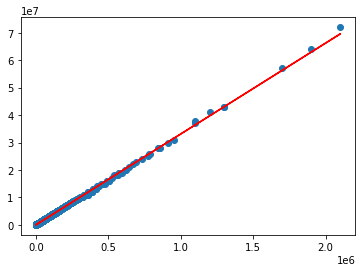

In [166]:
plt.scatter(X_train, y_train)

y_hat = X_train * lin_reg.coef_ + lin_reg.intercept_

plt.plot(X_train, y_hat, color='r') 

Adesso andiamo a vedere gli errori commessi dal nostro modello.

In [167]:
y_pred = regressor.predict(X_valid)
print ('MAE:', metrics.mean_absolute_error(y_valid, y_pred))
print ('MSE:', metrics.mean_squared_error(y_valid, y_pred))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, y_pred)))

MAE: 34861.252475206304
MSE: 9618870201.792099
RMSE: 98075.83903180283


Infine andiamo a valutare il nostro modello utilizzando il modello nullo.

In [168]:
mean_views = ted['views'].mean()

# create la nuova x con lo stesso numero di campioni del dataset originale, e con tutti i valori uguali al valore medio del diametro appena calcolato
null_model_y = [mean_views] * ted.shape[0]

# valutate il modello nullo usando le funzioni implementate
print ('MAE:', metrics.mean_absolute_error(y, null_model_y))
print ('MSE:', metrics.mean_squared_error(y, null_model_y))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(y, null_model_y)))

MAE: 1615887.8088377216
MSE: 12721847461028.2
RMSE: 3566769.891796806


OSSERVAZIONI SUL MODELLO NULLO

### **Esiste un periodo migliore dove pubblicare un talk?**
Andiamo a vedere se sono presenti dei periodi dove vengono pubblicati la maggio parte di talk per determinare quando è meglio pubblicare il nostro. 

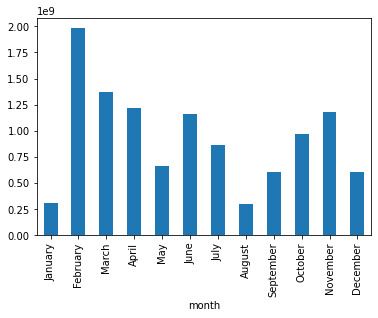

In [169]:
import calendar
ted['month'] = ted['date'].str.split(' ', expand=True)[0]

ted['month']=pd.Categorical(ted['month'], categories=list(calendar.month_name)[1::], ordered=True)
views = ted.sort_values(by='month').groupby('month')['views'].sum()

views.plot(kind='bar')

Si può notare come il mese dove vengono pubblicati la maggior quantità di talk è febbraio. \
I mesi dove vengono pubblicati il minor numero di talk sono Gennaio, Agosto e Dicembre, quindi si può notare che corrispondono a quelli dove le persone tendono ad andare in vacanza. \
Forse conviene evitare tutti questi mesi perchè se non si è già famosi pubblicare un talk nello stesso mese dove vengono pubblicati la maggior parte dei talk potrebbe far si che le persone non lo guardino perchè interessate a vedere altri talk, ma conviene evitare anche i mesi con meno pubblicazioni perchè se le persone sono in vacanza si rischia che non siano interessate a vedere i talk.

### **Quali sono i talks e gli autori più di successo?**
Adesso andiamo a vedere quali sono i talks e gli autori che hanno avuto il maggior successo per poter prendere spunto da loro e poter analizzare i loro punti di forza. \
Partiamo guardando i talk con il maggior numero di likes.

In [170]:
bestTalksByLikes = ted.sort_values(by='likes', ascending=False, ignore_index=True).nlargest(20, 'likes')[['author', 'title', 'date', 'likes']]
bestTalksByLikes

,author,title,date,likes
0,Sir Ken Robinson,Do schools kill creativity?,February 2006,2100000
1,Amy Cuddy,Your body language may shape who you are,June 2012,1900000
2,Tim Urban,Inside the mind of a master procrastinator,February 2016,1800000
3,Brené Brown,The power of vulnerability,June 2010,1700000
4,Simon Sinek,How great leaders inspire action,September 2009,1700000
5,Julian Treasure,How to speak so that people want to listen,June 2013,1400000
6,Sam Berns,My philosophy for a happy life,October 2013,1300000
7,Bill Gates,The next outbreak? We're not ready,March 2015,1300000
8,Robert Waldinger,What makes a good life? Lessons from the longe...,November 2015,1200000
9,Mary Roach,10 things you didn't know about orgasm,February 2009,1100000


Adesso andiamo a vedere quali sono gli autori che hanno ottenuto il maggior numero di likes

In [171]:
#TODO: Autori con il maggior numero di like

Siccome abbiamo visto che è presente una forte correlazione tra numero di like e numero di view, andiamo a vedere anche quali sono i talks e gli autori con il maggior numero di view.

In [172]:
bestTalksByViews = ted.sort_values(by='views', ascending=False, ignore_index=True).nlargest(20, 'views')[['author', 'title', 'date', 'views']]
bestTalksByViews

,author,title,date,views
0,Sir Ken Robinson,Do schools kill creativity?,February 2006,72000000
1,Amy Cuddy,Your body language may shape who you are,June 2012,64000000
2,Tim Urban,Inside the mind of a master procrastinator,February 2016,60000000
3,Simon Sinek,How great leaders inspire action,September 2009,57000000
4,Brené Brown,The power of vulnerability,June 2010,56000000
5,Julian Treasure,How to speak so that people want to listen,June 2013,49000000
6,Sam Berns,My philosophy for a happy life,October 2013,43000000
7,Bill Gates,The next outbreak? We're not ready,March 2015,43000000
8,Robert Waldinger,What makes a good life? Lessons from the longe...,November 2015,41000000
9,Cameron Russell,"Looks aren't everything. Believe me, I'm a model.",October 2012,38000000


In [173]:
#TODO: Autori con il maggior numero di view

### **Per aver successo serve pubblicare molti talk?**
Un'altra cosa che vogliamo capire è se è necessario pubblicare molti talk per ottenere molti like. \
Partiamo confrontando gli autori che hanno ottenuto il maggior numero di like con quelli che hanno prodotto il maggior numero di talk.

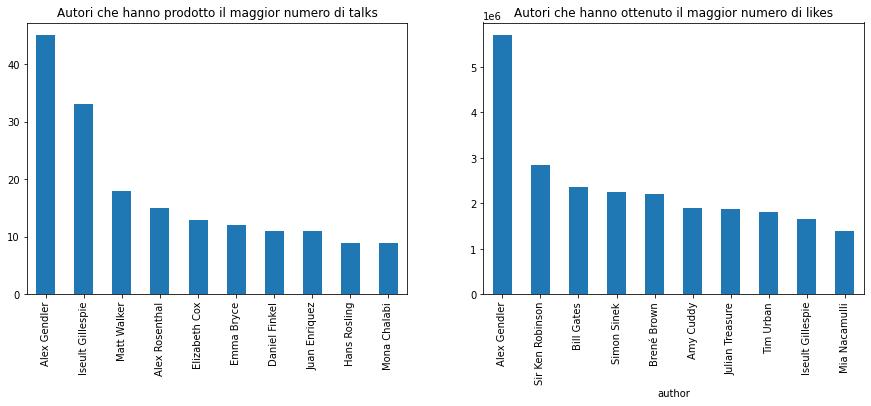

In [174]:
authorProduct = ted.sort_values(by='author')['author'].value_counts()
authorProductLimited = authorProduct.nlargest(10)


authorLikes = ted.sort_values(by='author').groupby('author')['likes'].sum() #normalizzazione
authorLikesLimited = authorLikes.nlargest(10)



plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
authorProductLimited.plot(kind='bar', title="Autori che hanno prodotto il maggior numero di talks")
plt.subplot(1,2,2)
authorLikesLimited.plot(kind='bar', title="Autori che hanno ottenuto il maggior numero di likes")

Si può notare come, tranne Alex Gendler e Iseult Gillespie, la maggior parte degli autori con il maggior numero di views non corrispondano con quelli che hanno pubblicato più talks. \
Andiamo a vedere se è presente una correlazione tra il numero di talks pubblicati ed il numero di views di un autore.

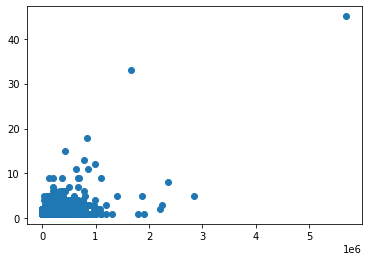

In [175]:
plt.scatter(authorLikes, authorProduct.sort_index())

In [176]:
authorLikes.sort_index().corr(authorProduct.sort_index())

0.6164811152651448

È presente una moderata correlazione tra numero di talks prodotti e numero di views registrate.

### **Quali temi trattare?**
Adesso cerchiamo di capire quali sono i temi trattati maggiormente e se sono presenti nei talk di maggior successo. \
Per farlo andiamo a vedere quali sono le parole maggiormente utilizzate all'interno dei titoli.


In [177]:
import nltk
from nltk.corpus import stopwords
from termcolor import colored
nltk.download('stopwords')

def getWords(ds):
  banned = list(stopwords.words('english'))+['—', 'new', 'us', 'could', 'we\'re']
  wordsList=[]
  for v in ds.values:
    for w in v.split():
      if w.lower() not in banned:
        wordsList.append(w.lower())
  words = pd.DataFrame({'word':wordsList})['word'].value_counts().nlargest(6)
  return words

def getWordsColor(w, c):
  word_color=dict()
  count=0
  for w in words.index: 
    word_color[w]=c[count]
    count+=1
  return word_color

def plotWords(w, c):
  ax = words.plot(kind='bar')
  count=0
  for rect in ax.patches:
    rect.set_color(c[count])
    count+=1

def printTitleColor(t, w_dictionary):
  for title in t:
    for w in title.split():
      if w.lower() in w_dictionary:
        print(colored(w, w_dictionary[w.lower()]), end=' ')
      else:
        print(w, end=' ')
    print()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


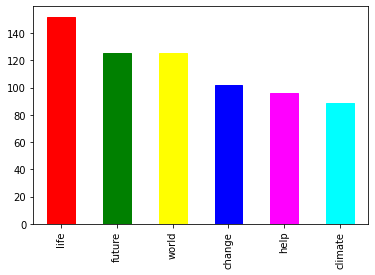

In [178]:
color=['red','green','yellow','blue','magenta','cyan']

words=getWords(ted['title'])
word_color=getWordsColor(words,color)
plotWords(words,color)

Tra le paroli più comuni si può notare come siano presenti, quasi nella stessa quantità, le parole `climate` e `change` suggerendo come uno dei temi più importanti degli ultimi anni, ossia il cambiamento climatico, venga trattato molto frequentemente anche nei talks presenti su Ted Talks. \
Andiamo a verificare quante volte compaiono nello stesso titolo.

In [179]:
countBoth=0
countClimate=0
countChange=0
for v in ted['title'].values:
  v = v.lower()
  if 'climate' in v and 'change' in v:
    countBoth+=1
  if 'climate' in v:
    countClimate+=1
  if 'change' in v:
    countChange+=1
print(f"'Climate' compare {countClimate} volte, 'Change' compare {countChange} volte e compaiono entrambe nello stesso titolo {countBoth} volte")

'Climate' compare 92 volte, 'Change' compare 136 volte e compaiono entrambe nello stesso titolo 48 volte


`Change` ovviamente compare più volte essendo anche una parola che può essere usata in diversi abiti, ma è interessante notare come più del 50% delle volte la parola `Climate` compaia insieme a `Change`. \
Adesso che abbiamo trovato le parole più usate andiamo a vedere se sono presenti all'interno dei titoli dei talk di maggior successo.


In [180]:
bestTalksByLikes = ted.sort_values(by='likes', ascending=False, ignore_index=True).nlargest(50, 'likes')['title']
printTitleColor(bestTalksByLikes, word_color)

Do schools kill creativity? 
Your body language may shape who you are 
Inside the mind of a master procrastinator 
The power of vulnerability 
How great leaders inspire action 
How to speak so that people want to listen 
My philosophy for a happy life 
The next outbreak? We're not ready 
What makes a good life? Lessons from the longest study on happiness 
10 things you didn't know about orgasm 
Why people believe they can't draw 
Looks aren't everything. Believe me, I'm a model. 
The orchestra in my mouth 
How to spot a liar 
The art of misdirection 
The power of introverts 
The danger of a single story 
How I held my breath for 17 minutes 
How to make stress your friend 
How to stop screwing yourself over 
The future we're building — and boring 
My stroke of insight 
The puzzle of motivation 
Strange answers to the psychopath test 
10 ways to have a better conversation 
Questions no one knows the answers to 
Grit: The power of passion and perseverance 
The happy secret to better work 

Si può notare come, tranne una volta `life` e `future`, le parole che abbiamo trovato che vengono utilizzate maggiormente, non compaiono nei primi 50 titoli, quindi non sono presenti legami tra temi trattati e numero di visualizzazioni. \
Andiamo quindi a vedere le parole più utilizzate nei primi 50 talks con più likes e vediamo se sono presenti temi ricorrenti.


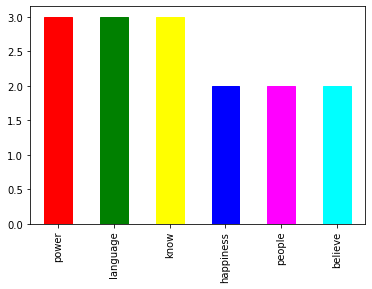

In [181]:
words=getWords(bestTalksByLikes)
word_color=getWordsColor(words,color)
plotWords(words,color)

In [182]:
printTitleColor(bestTalksByLikes, word_color)

Do schools kill creativity? 
Your body language may shape who you are 
Inside the mind of a master procrastinator 
The power of vulnerability 
How great leaders inspire action 
How to speak so that people want to listen 
My philosophy for a happy life 
The next outbreak? We're not ready 
What makes a good life? Lessons from the longest study on happiness 
10 things you didn't know about orgasm 
Why people believe they can't draw 
Looks aren't everything. Believe me, I'm a model. 
The orchestra in my mouth 
How to spot a liar 
The art of misdirection 
The power of introverts 
The danger of a single story 
How I held my breath for 17 minutes 
How to make stress your friend 
How to stop screwing yourself over 
The future we're building — and boring 
My stroke of insight 
The puzzle of motivation 
Strange answers to the psychopath test 
10 ways to have a better conversation 
Questions no one knows the answers to 
Grit: The power of passion and perseverance 
The happy secret to better work 

Analizzando le parole trovate, è possibile notare come nella top 50 dei talks più visti siano presenti:

*   Tre talks dove vengono analizzati i punti di forza (ed hanno in comune la parola `power`)
*   Tre talks dove viene analizzato il linguaggio (ed hanno in comune la parola `language`)
*   Due talks dove viene trattata la felicità (ed hanno in comune la parola `happiness`)


Adesso andiamo a vedere quali sono i talks con il maggior numero di views e con il maggior numero di likes. Siccome è presente questa forte correlazione ci aspettiamo di trovare più o meno gli stessi talks.

Come ci aspettavamo, la maggior parte dei talks con più views sono anche quelli con più likes. Adesso andiamo a vedere quali sono i talks con il miglior rapporto `#likes/#views`.

In [183]:
ted['ratio']=ted['likes'].div(ted['views'])
ted.sort_values(by='ratio', ascending=False, ignore_index=True).nlargest(20, 'ratio')[['author', 'title', 'ratio']]

,author,title,ratio
0,Coby Everton,The importance of queer allyship in the classroom,0.032900
1,Mackenzie Dalrymple,Three stories of Scotland,0.032636
2,Mathieu Lamiaux,Imagining a new future for health systems in A...,0.032600
3,Scott Nguyen,Solar energy can help put power back in the ha...,0.032600
4,Paul S. Kindstedt,A brie(f) history of cheese,0.032545
5,Tim Ferriss,Why you should define your fears instead of yo...,0.032500
6,Emily Esfahani Smith,There's more to life than being happy,0.032455
7,Alejandro Chaskielberg,Cómo usar el arte de la fotografía para restau...,0.032417
8,Tony Buffington,Why do cats act so weird?,0.032364
9,Rana Novack,How we'll predict the next refugee crisis,0.032333


Si può osservare che nessuno dei talks più visti o con più likes compare nella classifica dei talks con il rapporto migliore.

Andiamo a vedere quali sono gli autori che hanno prodotto il maggior numero di talks e quali hanno ottenuto il maggior numero di views per vedere se è presente una correlazione tra le due cose.

Adesso vogliamo andare a vedere se è presente una preferenza sui mesi dove pubblicare i talks.

Si può notare come nei mesi dove sono presenti le festività (gennaio, agosto e dicembre) sono stati pubblicati il minor numero di talks.

Adesso andiamo a vedere l'andamento annuale di visualizzazioni e pubblicazioni di nuovi talks.

In [184]:
ted['year'] = [int(x) for x in ted['date'].str.split(' ', expand=True)[1]]

È possibile osservare che l'andamento del numero di pubblicazioni in un anno è simile a quello del numero di views, ma dal 2015 al 2019 i due andamenti sono andati diversamente, infatti mentre dal 2015 si è iniziato a registrare un calo nel numero di views, il numero di pubblicazioni ha continuato a crescere sino al 2019.
Per osservare meglio i due andamenti andiamo a sovrapporre i due grafici.

È possibile notare come in realtà sino al 2019 sono stati prodotti un numero sempre maggiore di talks, quindi questo ci fa pensare che a partire dal 2015 la gente ha iniziato a perdere interesse siccome è presente un aumento di talks prodotti (sino al 2019), ma una diminuzione nelle views.
<br><br>
Per vedere meglio i risultati ottenuti, andiamo a creare un grafico contenente i due risultati ottenuti. In questo caso i dati vengono normalizzati. Vengono rappresentati con la riga rossa il numero di talks prodotti e con la riga blu il numero di views registrate.

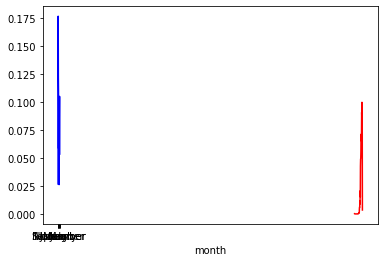

In [185]:
yearN = ted['year'].value_counts(normalize=True).sort_index()
viewsN = views.div(views.sum())

ax = viewsN.plot(kind='line', color='blue')
ax = yearN.plot(ax=ax, kind='line', color='red')

Un altro andamento che vogliamo osservare è quello del numero medio di views per anno. Sicuramente ci aspettiamo che a partire dal 2015 sia calato siccome, come abbiamo visto in precedenza, dal 2015 al 2019 sono aumentati il numero di talks prodotti, ma diminuiva il numero di views.

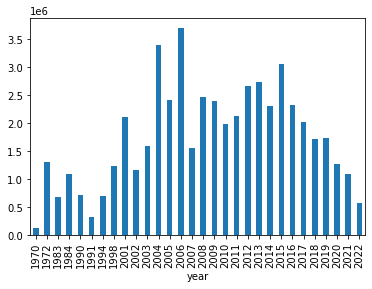

In [186]:
meanV = ted.groupby('year')['views'].mean().sort_index()
ax = meanV.plot(kind='bar')

Come ci aspettavamo a partire dal 2015 c'è stata una continua diminuzione del numero medio di views. Gli anni in cui le views medie sono andate meglio sono il 2004 ed il 2006. Andiamo a vedere quali sono i talks con più views pubblicati in quei due anni.


In [187]:
ted[ted['year'] == 2004].sort_values(by='views', ascending=False, ignore_index=True).nlargest(10, 'views')[['author', 'title', 'views']]

,author,title,views
0,Dan Gilbert,The surprising science of happiness,19000000
1,Keith Barry,Brain magic,18000000
2,Matthieu Ricard,The habits of happiness,10000000
3,Malcolm Gladwell,"Choice, happiness and spaghetti sauce",9200000
4,Ze Frank,Nerdcore comedy,7300000
5,Mihaly Csikszentmihalyi,"Flow, the secret to happiness",6800000
6,Martin Seligman,The new era of positive psychology,6600000
7,Steven Levitt,The freakonomics of crack dealing,4200000
8,Susan Savage-Rumbaugh,The gentle genius of bonobos,2900000
9,Al Seckel,Visual illusions that show how we (mis)think,2600000


In [188]:
ted[ted['year'] == 2006].sort_values(by='views', ascending=False, ignore_index=True).nlargest(10, 'views')[['author', 'title', 'views']]

,author,title,views
0,Sir Ken Robinson,Do schools kill creativity?,72000000
1,Hans Rosling,The best stats you've ever seen,15000000
2,Helen Fisher,"Why we love, why we cheat",12000000
3,Michael Shermer,Why people believe weird things,7800000
4,Jeff Han,The radical promise of the multi-touch interface,4800000
5,Julia Sweeney,Letting go of God,4800000
6,Rick Warren,A life of purpose,4200000
7,Dan Dennett,Let's teach religion — all religion — in schools,4099999
8,Al Gore,Averting the climate crisis,3600000
9,Sirena Huang,An 11-year-old's magical violin,3300000


Si può notare come solo nel 2006 è presente uno dei 20 talks più visti in assoluto. Adesso andiamo a confrontare la distribuzione delle views in questi due anni con la distribuzione generale.

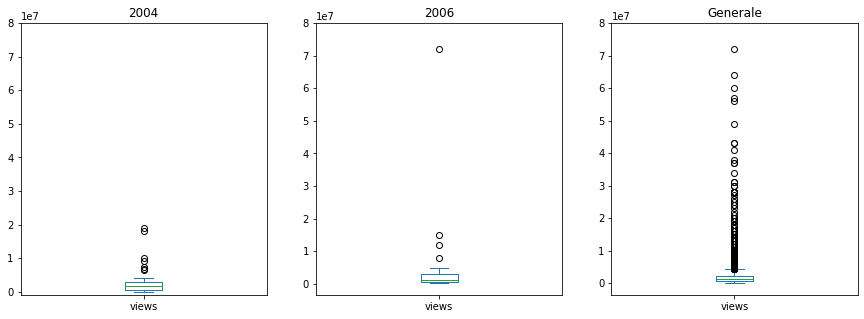

In [189]:
plt.figure(figsize=(15,5))
labels = np.arange(0, 9e7, 1e7)

plt.subplot(1,3,1)
ax = ted[ted['year'] == 2004]['views'].plot(kind='box', title='2004')
_ = ax.set_yticks(labels)

plt.subplot(1,3,2)
ax = ted[ted['year'] == 2006]['views'].plot(kind='box', title='2006')
_ = ax.set_yticks(labels)

plt.subplot(1,3,3)
ax = ted['views'].plot(kind='box', title='Generale')
_ = ax.set_yticks(labels)

Per poter vedere meglio la distribuzione, andiamo a vedere la distribuzione considerando solo i talks con meno di 1e7 views.

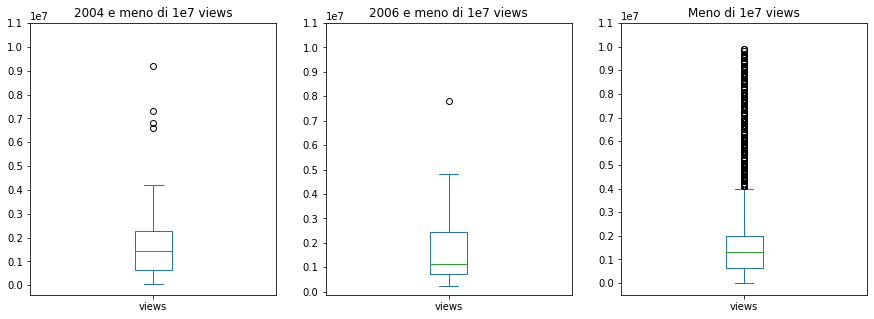

In [190]:
plt.figure(figsize=(15,5))
labels = np.arange(0, 1e7+2e6, 1e6)


plt.subplot(1,3,1)
ax = ted[(ted['year'] == 2004) & (ted['views'] < 1e7)]['views'].plot(kind='box', title='2004 e meno di 1e7 views')
_ = ax.set_yticks(labels)

plt.subplot(1,3,2)
ax = ted[(ted['year'] == 2006) & (ted['views'] < 1e7)]['views'].plot(kind='box', title='2006 e meno di 1e7 views')
_ = ax.set_yticks(labels)

plt.subplot(1,3,3)
ax = ted[ted['views'] < 1e7]['views'].plot(kind='box', title='Meno di 1e7 views')
_ = ax.set_yticks(labels)

Si può osservare che la distribuzione delle views dei talks prodotti nel 2004 e nel 2006 e quella generale sono molto simili tra loro.

Un altro tipo di analisi che vogliamo fare è sui titoli, infatti vogliamo vedere se sono presenti delle parole che compaiono la maggior parte delle volte per provare a trovare le tematiche più comuni.